<a href="https://colab.research.google.com/github/cristina-ap/PMP-2024/blob/main/tema_9_lab_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

Ex. 1.

Se doreşte modelarea probabilităţii ca un student să promoveze un examen în funcţie de numărul de
ore de studiu pe săptămână. Datele sintetice arată astfel:

  ore de studiu: 1 3 4 5 6 8

  promovare (0/1): 0 0 1 1 1 1

Construiţi un model bayesian de regresie logistică care:

a) să estimeze coeficienţii regresiei (interceptul şi panta), probabilitatea de mai sus şi frontiera de decizie;

Output()

Output()

ERROR:pymc.stats.convergence:There were 166 divergences after tuning. Increase `target_accept` or reparameterize.


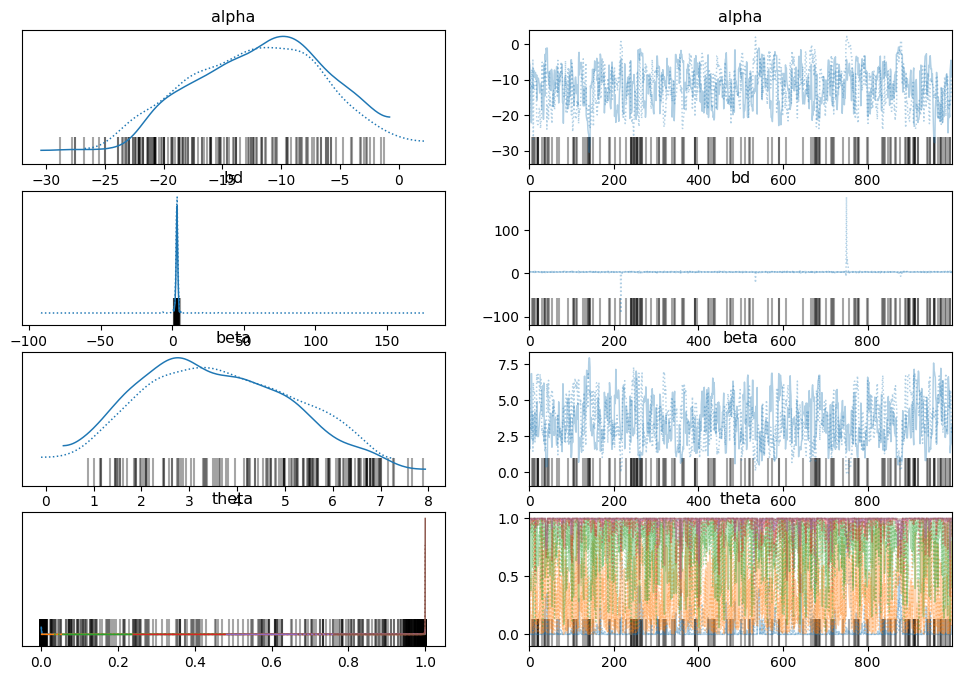

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-11.857,5.596,-22.085,-2.133,0.317,0.225,301.0,312.0,1.01
beta,3.572,1.588,0.702,6.386,0.089,0.063,306.0,336.0,1.00


In [ ]:
x = np.array([1, 3, 4, 5, 6, 8])
y = np.array([0, 0, 1, 1, 1, 1])

with pm.Model() as model1:
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10)

  mu = alpha + pm.math.dot(x, beta)

  theta = pm.Deterministic('theta', pm.math.sigmoid(mu))
  bd = pm.Deterministic('bd', -alpha/beta)

  y1 = pm.Bernoulli('y1', p=theta, observed=y)
  idata_0 = pm.sample(1000, tune=1000, return_inferencedata=True)

pm.plot_trace(idata_0)
plt.show()
az.summary(idata_0, var_names=["alpha","beta"])


b) să ofere intervale de credibilitate (HDI) pentru frontiera de decizie.

/usr/local/lib/python3.10/dist-packages/arviz/plots/hdiplot.py:161: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


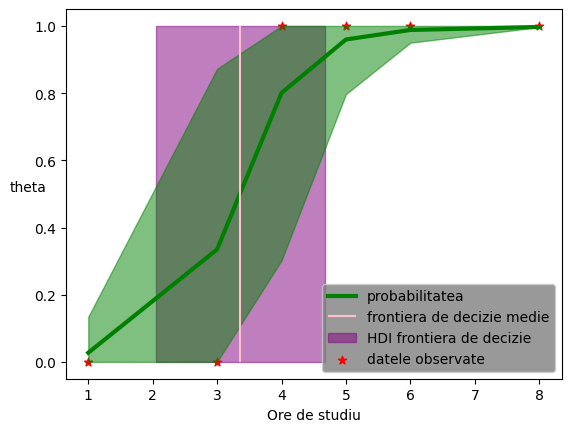

In [ ]:
posterior_0 = idata_0.posterior.stack(samples=("chain", "draw"))
theta = posterior_0['theta'].mean("samples")
idx = np.argsort(x)

plt.plot(x[idx], theta[idx], color='green', lw=3, label="probabilitatea")
plt.vlines(posterior_0['bd'].mean(), 0, 1, color='pink', label="frontiera de decizie medie")

bd_hpd = az.hdi(posterior_0['bd'].values)

plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='purple', alpha=0.5, label="HDI frontiera de decizie")
plt.scatter(x, y, marker='*', color='red', label = "datele observate")

az.plot_hdi(x, posterior_0['theta'].T, color='green', smooth=False,)
plt.xlabel("Ore de studiu")
plt.ylabel('theta', rotation=0)
plt.legend(facecolor='gray')


Ex. 2.

Ce factori determină admiterea la facultate în Statele Unite? În fişierul Admission.csv au fost strânse
datele a 400 de cazuri de admitere la o facultate. “Admission” este un răspuns binar, cu 1 sau 0 indicând
“admis”, respectiv “respins”. Sunt de asemenea disponibile scorul la testul GRE şi rezultatul mediu din liceu,
GPA (undergraduate grade point average). Fie pi probabilitatea ca studentul cu nr. i să fie admis.
Considerăm modelul logistic

pi = logistic(β0 + β1xi1 + β2xi2),

unde xi1 şi xi2 sunt scorul GRE, respectiv GPA pentru studentul i.

a) Folosind distribuţii a priori slab informative asupra parametrilor β0, β1 şi β2, folosiţi PyMC pentru a
simula un eşantion suficient de mare (construi modelul) din distribuţia a posteriori.

b) Care este, în medie, graniţa de decizie pentru acest model? Reprezentaţi de asemenea grafic o zonă în
jurul acestei grafic care să reprezinte un interval 94% HDI.

Output()

Output()

Text(0, 0.5, 'GPA')

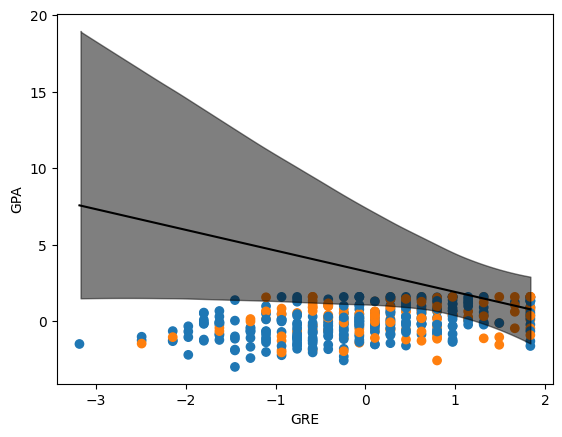

In [ ]:
data = pd.read_csv("Admission.csv")
GRE_mean, GRE_std = data['GRE'].mean(), data['GRE'].std()
GPA_mean, GPA_std = data['GPA'].mean(), data['GPA'].std()

data['GRE'] = (data['GRE'] - data['GRE'].mean()) / data['GRE'].std()
data['GPA'] = (data['GPA'] - data['GPA'].mean()) / data['GPA'].std()

x_n = ['GRE', 'GPA']
x_1 = data[x_n].values
y_data = np.array(data['Admission'])

with pm.Model() as model2:
  beta_0 = pm.Normal('beta_0', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=len(x_n))
  mu = beta_0 + pm.math.dot(x_1, beta)

  theta = pm.Deterministic('theta', pm.math.sigmoid(mu))

  bd = pm.Deterministic('bd', -beta_0/beta[1] - beta[0]/beta[1] * x_1[:,0])
  yl = pm.Bernoulli('yl', p=theta, observed=y_data)

  idata_1 = pm.sample(2000, return_inferencedata=True)

idx = np.argsort(x_1[:,0])
bd = idata_1.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x_1[:,0], x_1[:,1], c=[f'C{x}' for x in y_data])

plt.plot(x_1[:,0][idx], bd, color='k');
az.plot_hdi(x_1[:,0], idata_1.posterior['bd'], color='k')

plt.xlabel(x_n[0])
plt.ylabel(x_n[1])





c) Să presupunem că un student are un scor GRE de 550 şi un GPA de 3.5. Construiţi un interval de 90%
HDI pentru probabilitatea ca acest student să fie admis.

In [ ]:
GRE_1 = 550
GPA_1 = 3.5
GRE_1_s = (GRE_1 - GRE_mean) / GRE_std
GPA_1_s = (GPA_1 - GPA_mean) / GPA_std

beta_0_samples = idata_1.posterior['beta_0'].values.flatten()
beta_samples = idata_1.posterior['beta'].values.reshape(-1, len(x_n))

mu_samples = beta_0_samples + beta_samples[:, 0] * GRE_1_s + beta_samples[:, 1] * GPA_1_s

theta_samples = 1 / (1 + np.exp(-mu_samples))

mean_prob = np.mean(theta_samples)
hdi = az.hdi(theta_samples, hdi_prob=0.9)

print("Probabilitatea medie:", mean_prob)
print("Intervalul de credibilitate HDI:", hdi)

Probabilitatea medie: 0.30398742598029704
Intervalul de credibilitate HDI: [0.26186146 0.35291214]


d) Dar dacă studentul are un scor GRE de 500 şi un GPA de 3.2? (refaceţi exerciţiul anterior cu aceste
date) Cum justificaţi diferenţa?

In [ ]:
GRE_2 = 500
GPA_2 = 3.2
GRE_2_s = (GRE_2 - GRE_mean) / GRE_std
GPA_2_s = (GPA_2 - GPA_mean) / GPA_std

beta_0_samples = idata_1.posterior['beta_0'].values.flatten()
beta_samples = idata_1.posterior['beta'].values.reshape(-1, len(x_n))

mu_samples = beta_0_samples + beta_samples[:, 0] * GRE_2_s + beta_samples[:, 1] * GPA_2_s

theta_samples = 1 / (1 + np.exp(-mu_samples))

mean_prob = np.mean(theta_samples)
hdi = az.hdi(theta_samples, hdi_prob=0.9)

print("Probabilitatea medie:", mean_prob)
print("Intervalul de credibilitate HDI:", hdi)

Probabilitatea medie: 0.23297891626961045
Intervalul de credibilitate HDI: [0.18964458 0.2799134 ]
